# First iteration 

This project aims to build a machine learning-based trading strategy for Bitcoin that mimics how a human trader might think: using signals, confidence levels, and managing risk.

[*********************100%***********************]  1 of 1 completed


Log Loss: 0.9446
Brier Score: 0.3282


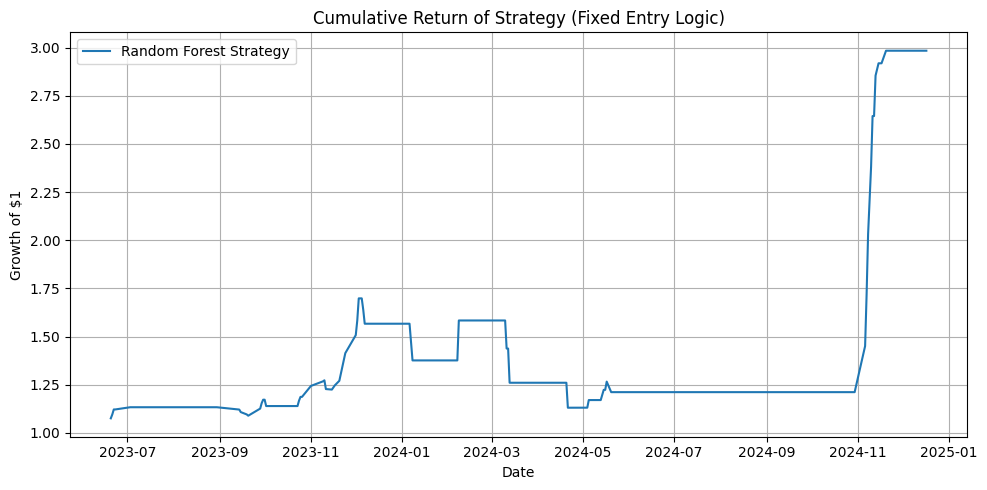

Trades Taken: 46
Final Return: 2.98x


In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss

df = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31")

# --- Flatten MultiIndex columns ---
df.columns = [col[0] for col in df.columns]

# --- FEATURE ENGINEERING ---
df["return_1d"] = df["Close"].pct_change()
df["ma_short"] = df["Close"].rolling(window=5).mean()
df["ma_long"] = df["Close"].rolling(window=20).mean()
df["volatility_10d"] = df["Close"].pct_change().rolling(window=10).std()
df["momentum_3d"] = df["Close"].pct_change(periods=3)

# --- SIGNAL ---
df["signal"] = (df["momentum_3d"] > 0.02) & (df["volatility_10d"] < 0.05)

# --- LABELING TRADES ---
df["entry_price"] = df["Close"].where(df["signal"])
df["exit_price"] = df["Close"].shift(-10).where(df["signal"])
df["label"] = np.where(
    (df["entry_price"].notna()) & (df["exit_price"] > df["entry_price"]),
    1.0,
    np.where(df["entry_price"].notna(), 0.0, np.nan)
)

# --- CLEANING ---
df["return_1d"] = df["return_1d"].fillna(0)
df["ma_short"] = df["ma_short"].bfill()
df["ma_long"] = df["ma_long"].bfill()
df["volatility_10d"] = df["volatility_10d"].fillna(0)
df_clean = df[df["label"].isin([0.0, 1.0])]

# --- FEATURES & LABELS ---
X = df_clean[["return_1d", "ma_short", "ma_long", "volatility_10d"]]
y = df_clean["label"]

# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

# --- TRAIN RANDOM FOREST MODEL ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- EVALUATION METRICS ---
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba):.4f}")

# --- BACKTESTING WITH FIXED ENTRY PRICES ---
df_test = df_clean.loc[X_test.index].copy()
df_test["predicted_proba"] = y_pred_proba
df_test["take_trade"] = df_test["predicted_proba"] > 0.5

# FIXED ENTRY PRICE
df_test["entry_price"] = df.loc[df_test.index, "Close"]

# Map positions to use row-based exit
position_map = {idx: i for i, idx in enumerate(df.index)}
df_test["row_pos"] = df_test.index.map(position_map)
df_test["exit_pos"] = df_test["row_pos"] + 10

# Drop rows near end with no exit
df_test = df_test[df_test["exit_pos"] < len(df)].copy()

# Get exit prices from future row
df_test["exit_price"] = df["Close"].iloc[df_test["exit_pos"]].values

# Calculate trade return
df_test["trade_return"] = (df_test["exit_price"] - df_test["entry_price"]) / df_test["entry_price"]
df_test["strategy_return"] = df_test["trade_return"] * df_test["take_trade"]
df_test["strategy_return"] = df_test["strategy_return"].fillna(0)
df_test["cumulative_return"] = (1 + df_test["strategy_return"]).cumprod()

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(df_test.index, df_test["cumulative_return"], label="Random Forest Strategy")
plt.title("Cumulative Return of Strategy (Fixed Entry Logic)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- SUMMARY ---
print(f"Trades Taken: {df_test['take_trade'].sum()}")
print(f"Final Return: {df_test['cumulative_return'].iloc[-1]:.2f}x")


## Statistics

In [49]:
# Filter only trades that were taken
taken_trades = df_test[df_test["take_trade"] == True]

# Print a sample of actual trades
print(taken_trades[["entry_price", "exit_price", "trade_return", "predicted_proba"]].head(10))

# Descriptive statistics
print("\nTrade return statistics:")
print(taken_trades["trade_return"].describe())

# Check how many were profitable
profitable = (taken_trades["trade_return"] > 0).sum()
total = len(taken_trades)
print(f"\nProfitable trades: {profitable}/{total} ({profitable / total:.1%})")


             entry_price    exit_price  trade_return  predicted_proba
Date                                                                 
2023-06-20  28327.488281  30477.251953      0.075890             0.54
2023-06-21  30027.296875  30590.078125      0.018742             0.65
2023-06-22  29912.281250  30620.769531      0.023686             0.60
2023-07-03  31156.439453  31476.048828      0.010258             0.61
2023-09-14  26539.673828  26256.826172     -0.010658             0.73
2023-09-15  26608.693359  26298.480469     -0.011658             0.78
2023-09-19  27211.117188  26911.720703     -0.011003             0.64
2023-09-20  27132.007812  26967.916016     -0.006048             0.72
2023-09-28  27021.546875  27935.089844      0.033808             0.74
2023-09-29  26911.720703  27583.677734      0.024969             0.89

Trade return statistics:
count    46.000000
mean      0.026602
std       0.073668
min      -0.123438
25%      -0.009505
50%       0.018820
75%       0.049500
m

In [50]:
print(f"Final Cumulative Return: {df_test['cumulative_return'].iloc[-1]:.2f}x")
print("Last 5 cumulative returns:")
print(df_test["cumulative_return"].tail())

Final Cumulative Return: 2.98x
Last 5 cumulative returns:
Date
2024-12-12    2.983606
2024-12-13    2.983606
2024-12-15    2.983606
2024-12-16    2.983606
2024-12-17    2.983606
Name: cumulative_return, dtype: float64


In [51]:
# Match start and end of test set
start_price = df.loc[df_test.index.min(), "Close"]
end_price = df.loc[df_test.index.max(), "Close"]
buy_hold_return = end_price / start_price

print(f"\nBuy & Hold return: {buy_hold_return:.2f}x")
print(f"Strategy return:    {df_test['cumulative_return'].iloc[-1]:.2f}x")


Buy & Hold return: 3.75x
Strategy return:    2.98x


In [53]:
# Daily risk-free rate (e.g., US 1-year ~5% annual ≈ 0.0002 daily)
risk_free_rate_daily = 0.0002

# Excess returns over risk-free rate
df_test["excess_return"] = df_test["strategy_return"] - risk_free_rate_daily

# Calculate Sharpe Ratio
mean_excess_return = df_test["excess_return"].mean()
std_dev = df_test["excess_return"].std()

if std_dev != 0:
    sharpe_ratio = (mean_excess_return / std_dev) * np.sqrt(365)
else:
    sharpe_ratio = np.nan

print(f"\nSharpe Ratio (annualized): {sharpe_ratio:.2f}")



Sharpe Ratio (annualized): 3.36


In [54]:
# Calculate rolling max (peak) of cumulative return
rolling_max = df_test["cumulative_return"].cummax()

# Drawdown: current equity / peak equity - 1
drawdown = (df_test["cumulative_return"] / rolling_max) - 1

# Max drawdown
max_drawdown = drawdown.min()

print(f"\nMaximum Drawdown: {max_drawdown:.2%}")



Maximum Drawdown: -33.41%


# Second iteration

[*********************100%***********************]  1 of 1 completed
C:\Users\Eirik\AppData\Local\Temp\ipykernel_13488\794228101.py:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["strategy_return"].fillna(0, inplace=True)


Trades Taken: 35
Final Return: 1.58x
Maximum Drawdown: -3.01%
Sharpe Ratio (Annualized): 4.02


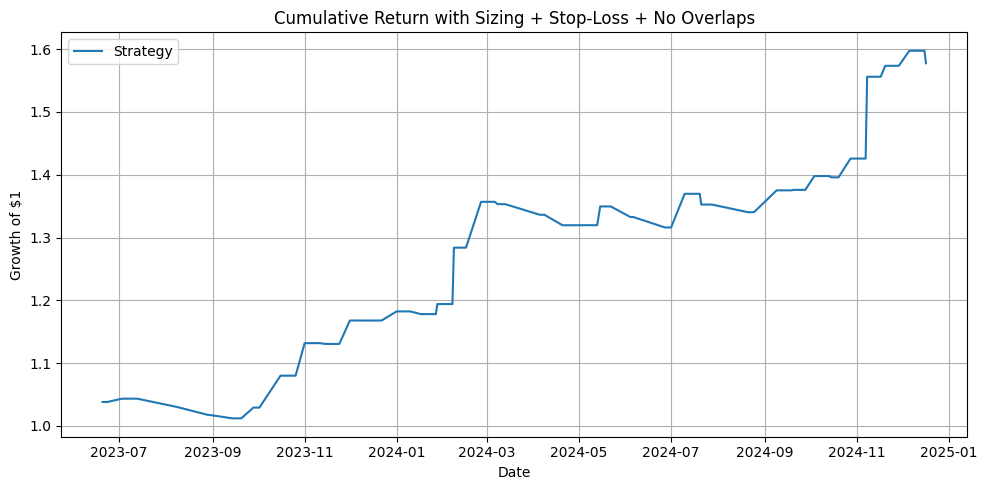

In [56]:
# --- IMPORTS ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss

# --- DOWNLOAD BTC DATA ---
df = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31")

# --- Flatten MultiIndex columns if needed ---
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# --- FEATURE ENGINEERING ---
df["return_1d"] = df["Close"].pct_change()
df["ma_short"] = df["Close"].rolling(window=5).mean()
df["ma_long"] = df["Close"].rolling(window=20).mean()
df["volatility_10d"] = df["Close"].pct_change().rolling(window=10).std()
df["momentum_3d"] = df["Close"].pct_change(periods=3)

# --- SIGNAL ---
df["signal"] = (df["momentum_3d"] > 0.02) & (df["volatility_10d"] < 0.05)

# --- LABEL TRADES ---
df["entry_price"] = df["Close"].where(df["signal"])
df["exit_price"] = df["Close"].shift(-10).where(df["signal"])
df["label"] = np.where(
    (df["entry_price"].notna()) & (df["exit_price"] > df["entry_price"]),
    1.0,
    np.where(df["entry_price"].notna(), 0.0, np.nan)
)

# --- CLEAN ---
df["return_1d"] = df["return_1d"].fillna(0)
df["ma_short"] = df["ma_short"].bfill()
df["ma_long"] = df["ma_long"].bfill()
df["volatility_10d"] = df["volatility_10d"].fillna(0)
df_clean = df[df["label"].isin([0.0, 1.0])]

# --- FEATURES & LABELS ---
X = df_clean[["return_1d", "ma_short", "ma_long", "volatility_10d"]]
y = df_clean["label"]

# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

# --- MODEL ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- BACKTEST ---
df_test = df_clean.loc[X_test.index].copy()
df_test["predicted_proba"] = y_pred_proba

# --- POSITION SIZING ---
def size_position(p):
    if p <= 0.5:
        return 0.25
    elif p <= 0.75:
        return 0.5
    elif p <= 0.9:
        return 1.0
    else:
        return 0.0

df_test["position_size"] = df_test["predicted_proba"].apply(size_position)

# --- ENTRY / EXIT LOGIC ---
df_test["entry_price"] = df.loc[df_test.index, "Close"]
position_map = {idx: i for i, idx in enumerate(df.index)}
df_test["row_pos"] = df_test.index.map(position_map)
df_test["exit_pos"] = df_test["row_pos"] + 10
df_test = df_test[df_test["exit_pos"] < len(df)].copy()
df_test["exit_price"] = df["Close"].iloc[df_test["exit_pos"].values].values

# --- STOP-LOSS ---
df_test["stop_price"] = df_test["entry_price"] * 0.95
df_test["final_exit_price"] = np.where(
    df_test["exit_price"] < df_test["stop_price"],
    df_test["stop_price"],
    df_test["exit_price"]
)

# --- AVOID OVERLAPS ---
trades = []
next_entry = -1
for i, row in df_test.iterrows():
    if row["row_pos"] > next_entry and row["position_size"] > 0:
        trades.append(True)
        next_entry = row["exit_pos"]
    else:
        trades.append(False)
df_test["take_trade"] = trades

# --- RETURNS ---
df_test["raw_return"] = (df_test["final_exit_price"] - df_test["entry_price"]) / df_test["entry_price"]
df_test["strategy_return"] = df_test["raw_return"] * df_test["position_size"] * df_test["take_trade"]
df_test["strategy_return"].fillna(0, inplace=True)
df_test["cumulative_return"] = (1 + df_test["strategy_return"]).cumprod()

# --- METRICS ---
final_return = df_test["cumulative_return"].iloc[-1]
rolling_max = df_test["cumulative_return"].cummax()
drawdown = df_test["cumulative_return"] / rolling_max - 1
max_drawdown = drawdown.min()

excess_returns = df_test["strategy_return"]
sharpe_ratio = (
    excess_returns.mean() / excess_returns.std() * np.sqrt(365)
    if excess_returns.std() > 0 else np.nan
)

# --- OUTPUT ---
print(f"Trades Taken: {df_test['take_trade'].sum()}")
print(f"Final Return: {final_return:.2f}x")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(df_test.index, df_test["cumulative_return"], label="Strategy")
plt.title("Cumulative Return with Sizing + Stop-Loss + No Overlaps")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Third iteration

[*********************100%***********************]  1 of 1 completed
C:\Users\Eirik\AppData\Local\Temp\ipykernel_13488\507971908.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["return_1d"].fillna(0, inplace=True)
C:\Users\Eirik\AppData\Local\Temp\ipykernel_13488\507971908.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

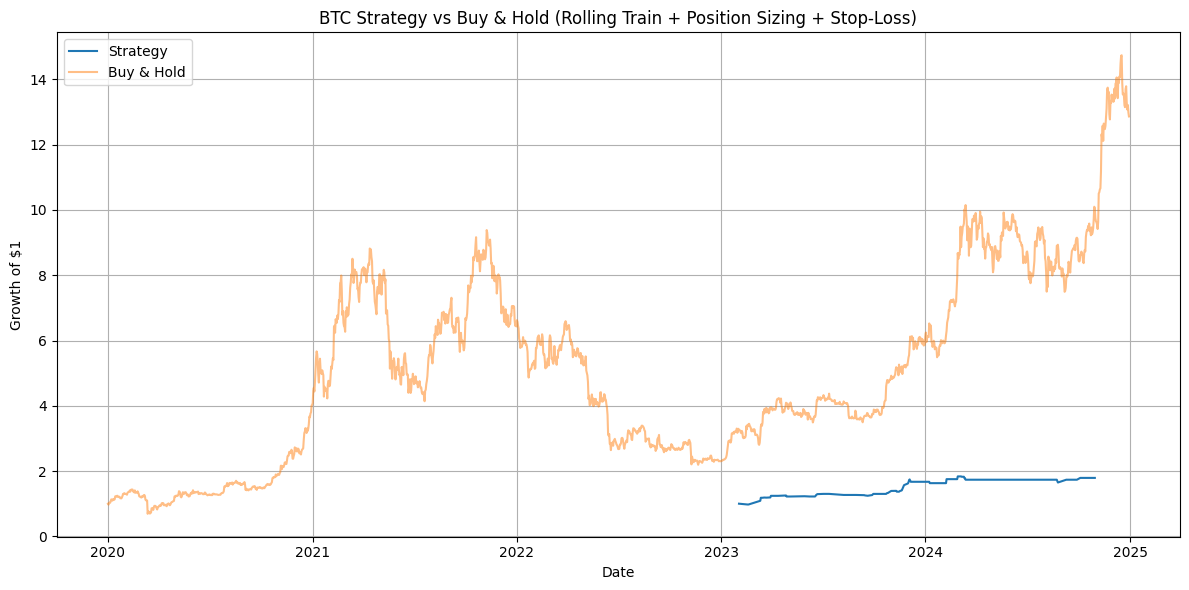

Trades Taken: 51
Final Return: 1.79x
Maximum Drawdown: 18.68%
Sharpe Ratio (Annualized): 3.55


In [57]:
# --- IMPORTS ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, brier_score_loss

# --- DOWNLOAD DATA ---
df = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31")
df.columns = [col[0] for col in df.columns]  # flatten columns if needed

# --- FEATURE ENGINEERING ---
df["return_1d"] = df["Close"].pct_change()
df["ma_short"] = df["Close"].rolling(window=5).mean()
df["ma_long"] = df["Close"].rolling(window=20).mean()
df["volatility_10d"] = df["Close"].pct_change().rolling(window=10).std()
df["momentum_3d"] = df["Close"].pct_change(periods=3)
df["signal"] = (df["momentum_3d"] > 0.02) & (df["volatility_10d"] < 0.05)

# --- LABELING ---
df["entry_price"] = df["Close"].where(df["signal"])
df["exit_price"] = df["Close"].shift(-10).where(df["signal"])
df["label"] = np.where(
    (df["entry_price"].notna()) & (df["exit_price"] > df["entry_price"]),
    1.0,
    np.where(df["entry_price"].notna(), 0.0, np.nan)
)

# --- CLEAN ---
df["return_1d"].fillna(0, inplace=True)
df["ma_short"].fillna(method="bfill", inplace=True)
df["ma_long"].fillna(method="bfill", inplace=True)
df["volatility_10d"].fillna(0, inplace=True)

df_clean = df[df["label"].isin([0.0, 1.0])].copy()

# --- ROLLING WINDOW TRAINING ---
lookback = 365
test_window = 30
features = ["return_1d", "ma_short", "ma_long", "volatility_10d"]
results = []

for start in range(0, len(df_clean) - lookback - test_window, test_window):
    train = df_clean.iloc[start:start+lookback]
    test = df_clean.iloc[start+lookback:start+lookback+test_window]

    X_train = train[features]
    y_train = train["label"]
    X_test = test[features]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    test = test.copy()
    test["predicted_proba"] = model.predict_proba(X_test)[:, 1]
    results.append(test)

df_test = pd.concat(results)
df_test["take_trade"] = df_test["predicted_proba"] > 0.5
df_test["entry_price"] = df.loc[df_test.index, "Close"]

# --- POSITION AND EXIT LOGIC ---
position_map = {idx: i for i, idx in enumerate(df.index)}
df_test["row_pos"] = df_test.index.map(position_map)
df_test["exit_pos"] = df_test["row_pos"] + 10
df_test = df_test[df_test["exit_pos"] < len(df)].copy()
df_test["exit_price"] = df["Close"].iloc[df_test["exit_pos"]].values

# --- POSITION SIZING ---
def get_size(prob):
    if prob <= 0.5:
        return 0.25
    elif prob <= 0.75:
        return 0.5
    elif prob <= 0.9:
        return 1.0
    else:
        return 0.0  # extremely high confidence not used here

df_test["size"] = df_test["predicted_proba"].apply(get_size)

# --- STOP LOSS AT 5% ---
df_test["raw_return"] = (df_test["exit_price"] - df_test["entry_price"]) / df_test["entry_price"]
df_test["trade_return"] = df_test["raw_return"].clip(lower=-0.05)

df_test["strategy_return"] = df_test["trade_return"] * df_test["take_trade"] * df_test["size"]
df_test["strategy_return"] = df_test["strategy_return"].fillna(0)
df_test["cumulative_return"] = (1 + df_test["strategy_return"]).cumprod()

# --- BUY & HOLD ---
df["buy_hold_return"] = df["Close"].pct_change().fillna(0)
df["buy_hold_cum_return"] = (1 + df["buy_hold_return"]).cumprod()

# --- PLOT ---
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test["cumulative_return"], label="Strategy")
plt.plot(df.index, df["buy_hold_cum_return"], label="Buy & Hold", alpha=0.5)
plt.title("BTC Strategy vs Buy & Hold (Rolling Train + Position Sizing + Stop-Loss)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- METRICS ---
final_return = df_test["cumulative_return"].iloc[-1]
trades_taken = df_test["take_trade"].sum()
max_drawdown = (df_test["cumulative_return"].cummax() - df_test["cumulative_return"]).max()
daily_returns = df_test["strategy_return"]
sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365)

print(f"Trades Taken: {int(trades_taken)}")
print(f"Final Return: {final_return:.2f}x")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Annualized): {sharpe:.2f}")


# Fourth iteration

[*********************100%***********************]  1 of 1 completed


Trades Taken: 180
Final Return: 3.54x
Maximum Drawdown: -20.06%
Sharpe Ratio (Annualized): 5.90


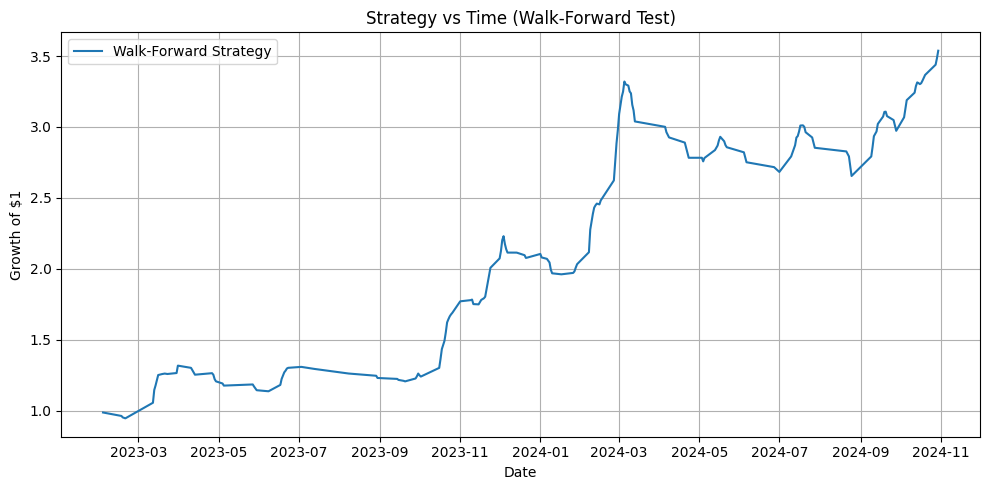

In [58]:
# --- IMPORTS ---
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# --- DOWNLOAD DATA ---
df = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31")
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# --- FEATURE ENGINEERING ---
df["return_1d"] = df["Close"].pct_change()
df["ma_short"] = df["Close"].rolling(window=5).mean()
df["ma_long"] = df["Close"].rolling(window=20).mean()
df["volatility_10d"] = df["Close"].pct_change().rolling(window=10).std()
df["momentum_3d"] = df["Close"].pct_change(periods=3)
df["signal"] = (df["momentum_3d"] > 0.02) & (df["volatility_10d"] < 0.05)

df["entry_price"] = df["Close"].where(df["signal"])
df["exit_price"] = df["Close"].shift(-10).where(df["signal"])
df["label"] = np.where(
    (df["entry_price"].notna()) & (df["exit_price"] > df["entry_price"]),
    1.0,
    np.where(df["entry_price"].notna(), 0.0, np.nan)
)

# --- CLEANING ---
df["return_1d"] = df["return_1d"].fillna(0)
df["ma_short"] = df["ma_short"].bfill()
df["ma_long"] = df["ma_long"].bfill()
df["volatility_10d"] = df["volatility_10d"].fillna(0)
df_clean = df[df["label"].isin([0.0, 1.0])].copy()

# --- WALK FORWARD TEST ---
features = ["return_1d", "ma_short", "ma_long", "volatility_10d"]
window_size = 365
step_size = 30
predicted_probas, indices = [], []

for start in range(0, len(df_clean) - window_size - step_size, step_size):
    train = df_clean.iloc[start : start + window_size]
    test = df_clean.iloc[start + window_size : start + window_size + step_size]
    if len(test) == 0: continue

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(train[features], train["label"])
    probas = model.predict_proba(test[features])[:, 1]
    
    predicted_probas.extend(probas)
    indices.extend(test.index)

# --- TRADING STRATEGY ---
df_test = df_clean.loc[indices].copy()
df_test["predicted_proba"] = predicted_probas
df_test["size"] = df_test["predicted_proba"].apply(lambda p: 0.25 if p <= 0.5 else 0.5 if p <= 0.75 else 1.0)
df_test["take_trade"] = df_test["size"] > 0

df_test["entry_price"] = df.loc[df_test.index, "Close"]
position_map = {idx: i for i, idx in enumerate(df.index)}
df_test["row_pos"] = df_test.index.map(position_map)
df_test["exit_pos"] = df_test["row_pos"] + 10
df_test = df_test[df_test["exit_pos"] < len(df)].copy()
df_test["exit_price"] = df["Close"].iloc[df_test["exit_pos"]].values

# --- STOP LOSS ---
df_test["stop_price"] = df_test["entry_price"] * 0.95
df_test["actual_exit"] = np.where(
    df_test["exit_price"] < df_test["stop_price"],
    df_test["stop_price"],
    df_test["exit_price"]
)

df_test["trade_return"] = (df_test["actual_exit"] - df_test["entry_price"]) / df_test["entry_price"]
df_test["strategy_return"] = df_test["trade_return"] * df_test["size"]
df_test["cumulative_return"] = (1 + df_test["strategy_return"]).cumprod()

# --- METRICS ---
max_dd = (df_test["cumulative_return"] / df_test["cumulative_return"].cummax() - 1).min()
sharpe = (df_test["strategy_return"].mean() / df_test["strategy_return"].std()) * np.sqrt(365)

print("Trades Taken:", int(df_test["take_trade"].sum()))
print(f"Final Return: {df_test['cumulative_return'].iloc[-1]:.2f}x")
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Sharpe Ratio (Annualized): {sharpe:.2f}")

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(df_test.index, df_test["cumulative_return"], label="Walk-Forward Strategy")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.title("Strategy vs Time (Walk-Forward Test)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Fifth iteration

[*********************100%***********************]  1 of 1 completed


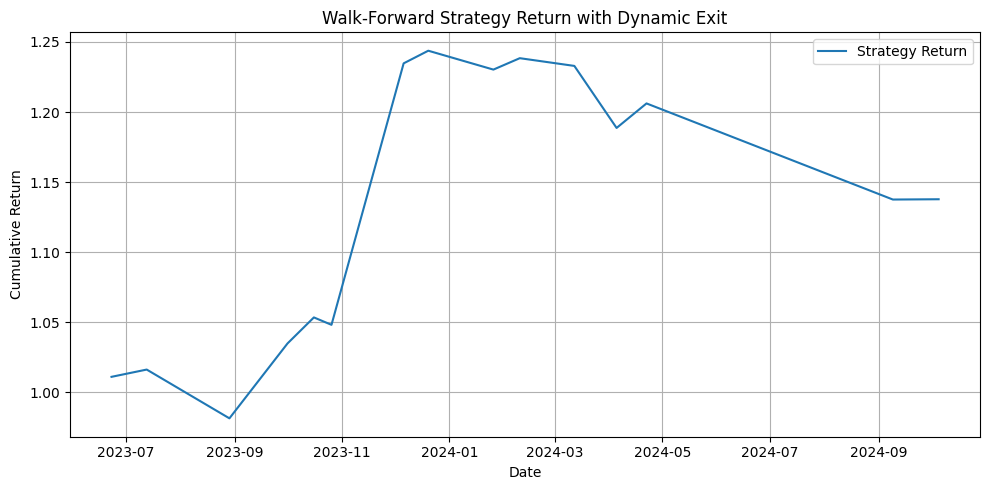

Trades Taken: 15
Final Return: 1.14x
Maximum Drawdown: -8.54%
Sharpe Ratio (Annualized): 3.54


In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt

# Download BTC data
df = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31")
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Feature engineering
df["return_1d"] = df["Close"].pct_change()
df["ma_short"] = df["Close"].rolling(window=5).mean()
df["ma_long"] = df["Close"].rolling(window=20).mean()
df["volatility_10d"] = df["Close"].pct_change().rolling(window=10).std()
df["momentum_3d"] = df["Close"].pct_change(periods=3)
df.dropna(inplace=True)

# Signal
df["signal"] = (df["momentum_3d"] > 0.02) & (df["volatility_10d"] < 0.05)
df["entry_price"] = df["Close"].where(df["signal"])
df["exit_price"] = df["Close"].shift(-10).where(df["signal"])
df["label"] = np.where(
    (df["entry_price"].notna()) & (df["exit_price"] > df["entry_price"]),
    1.0,
    np.where(df["entry_price"].notna(), 0.0, np.nan)
)

# Clean
df_clean = df.dropna(subset=["return_1d", "ma_short", "ma_long", "volatility_10d", "label"])

# Walk-forward logic
# --- FULL WALK-FORWARD CODE WITH CONFIDENCE TRACKING ---

initial_train_size = int(len(df_clean) * 0.7)
test_window = 30
features = ["return_1d", "ma_short", "ma_long", "volatility_10d"]
results = []

# Add confidence column to df in case it doesn't exist
df["confidence"] = pd.NA

for start in range(initial_train_size, len(df_clean) - test_window, test_window):
    train_df = df_clean.iloc[:start]
    test_df = df_clean.iloc[start:start + test_window].copy()
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(train_df[features], train_df["label"])

    active_trade = False
    entry_price = None
    entry_idx = None
    position_size = 0

    for idx, row in test_df.iterrows():
        # Format input to preserve feature names
        X_now = pd.DataFrame([row[features].values], columns=features)
        confidence = model.predict_proba(X_now)[0][1]
        price = row["Close"]

        # --- Store confidence in main df for diagnostics ---
        df.loc[idx, "confidence"] = confidence

        if not active_trade:
            if confidence > 0.5:
                active_trade = True
                entry_price = price
                entry_idx = idx
                if confidence <= 0.5:
                    position_size = 0.25
                elif confidence <= 0.75:
                    position_size = 0.5
                else:
                    position_size = 1.0
        else:
            return_since_entry = (price - entry_price) / entry_price
            confidence_now = confidence  # Already computed above

            # Stop loss or confidence drop exit
            if return_since_entry <= -0.05 or confidence_now < 0.5:
                trade_return = return_since_entry * position_size
                results.append((entry_idx, idx, entry_price, price, trade_return))
                active_trade = False
                entry_price = None
                position_size = 0


# Results
results_df = pd.DataFrame(results, columns=["entry_date", "exit_date", "entry_price", "exit_price", "trade_return"])
results_df["cumulative_return"] = (1 + results_df["trade_return"]).cumprod()

# Metrics
final_return = results_df["cumulative_return"].iloc[-1]
drawdowns = results_df["cumulative_return"] / results_df["cumulative_return"].cummax() - 1
max_drawdown = drawdowns.min()
sharpe_ratio = results_df["trade_return"].mean() / results_df["trade_return"].std() * np.sqrt(365)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results_df["exit_date"], results_df["cumulative_return"], label="Strategy Return")
plt.title("Walk-Forward Strategy Return with Dynamic Exit")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print(f"Trades Taken: {len(results_df)}")
print(f"Final Return: {final_return:.2f}x")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
